In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt

from mcopt import MorseComplex, MorseGraph, ot

# Configuration

In [4]:
datasets = [
  'wind1',
  'wind2',
  'wind3',
  'wind4',
  'wind5',
  'wind6',
  'wind7',
  'wind8',
  'wind9',
  'wind10',
  'wind11',
  'wind12',
  'wind13',
  'wind14',
  'wind15',
]

src = 'wind1'

dist = 'path_length'
measure = 'degree'

random_state = 42
alpha=0.5
m = 0.95

cmap = 'cool'

# Generate Morse Graphs

In [5]:
src_graph = MorseGraph.from_complex(MorseComplex.read(f'../gen_complexes/{src}')).sample(5)

results = {}

for dataset in datasets:
  if dataset == src: continue
  
  results[dataset] = {
    'graph': MorseGraph.from_complex(MorseComplex.read(f'../gen_complexes/{dataset}')).sample(5)
  }

## Initial Graphs

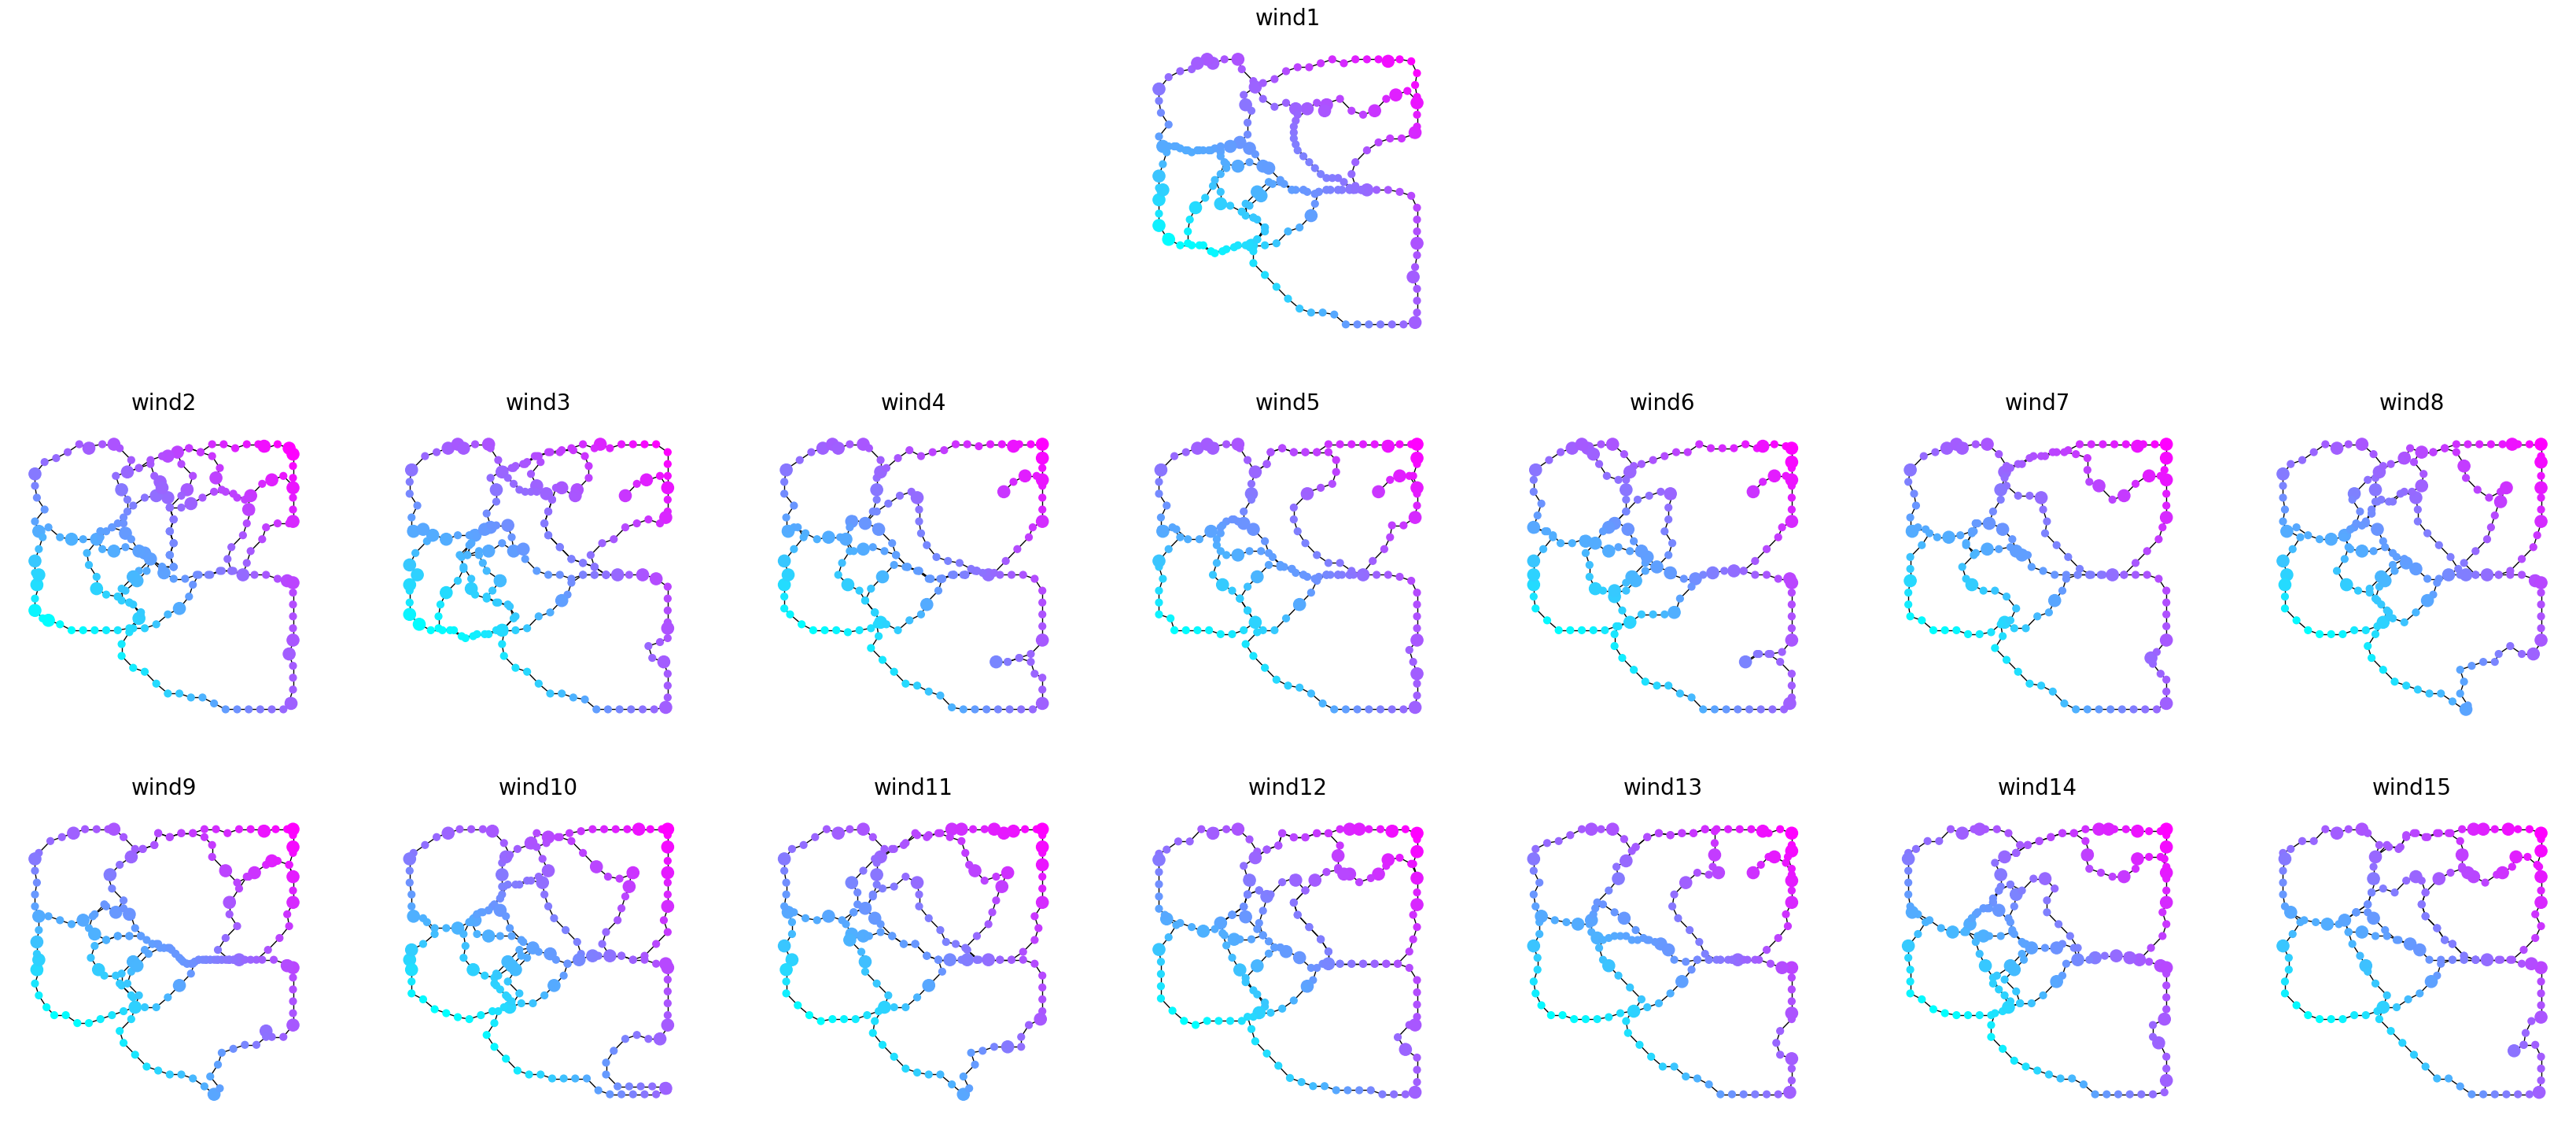

In [6]:
w = len(results) // 2
h = 3

fig, axes = plt.subplots(h, w, figsize=(6 * w, 6 * h))

for ax in axes.ravel():
  ax.set_axis_off()
  
src_pos = (0, w // 2)
src_graph.draw(
  ax=axes[src_pos],
  node_size=40,
  cmap=cmap
)
axes[src_pos].set_title(src, fontsize=20)

for ax, (name, res) in zip(axes.ravel()[w:], results.items()):
  res['graph'].draw(
    ax=ax,
    node_size=40,
    cmap=cmap
  )
  ax.set_title(name, fontsize=20)

# Run Experiment

In [7]:
src_mp = src_graph.to_mp(dist=dist, measure=measure)

for res in results.values():
  dest_graph = res['graph']
  dest_mp = dest_graph.to_mp(dist=dist, measure=measure)
  
  M = MorseGraph.attribute_cost_matrix(src_graph, dest_graph)
  
  res['GW'], _ = ot.GW(src_mp, dest_mp, random_G0=True, random_state=random_state)
  res['fGW'], _ = ot.fGW(src_mp, dest_mp, M, alpha=alpha, random_G0=True, random_state=random_state)
  res['fpGW'], _ = ot.fpGW(src_mp, dest_mp, m, M, alpha=alpha, random_G0=True, random_state=random_state)

In [8]:
def display_results(coupling_key):
  w = len(results) // 2
  h = 3

  fig, axes = plt.subplots(h, w, figsize=(6 * w, 6 * h))

  for ax in axes.ravel():
    ax.set_axis_off()
    
  src_pos = (0, w // 2)
  src_node_color = src_graph.color_by_position()
  
  src_graph.draw(
    ax=axes[src_pos],
    node_size=40,
    node_color=src_node_color,
    cmap=cmap
  )
  axes[src_pos].set_title(src, fontsize=20)

  for ax, (name, res) in zip(axes.ravel()[w:], results.items()):
    graph = res['graph']
    
    graph.draw(
      ax=ax,
      node_size=40,
      node_color=graph.color_by_coupling(src_node_color, res[coupling_key]),
      cmap=cmap
    )
    ax.set_title(name, fontsize=20)
    
  return fig

Text(0.5, 0.98, 'GW Transport')

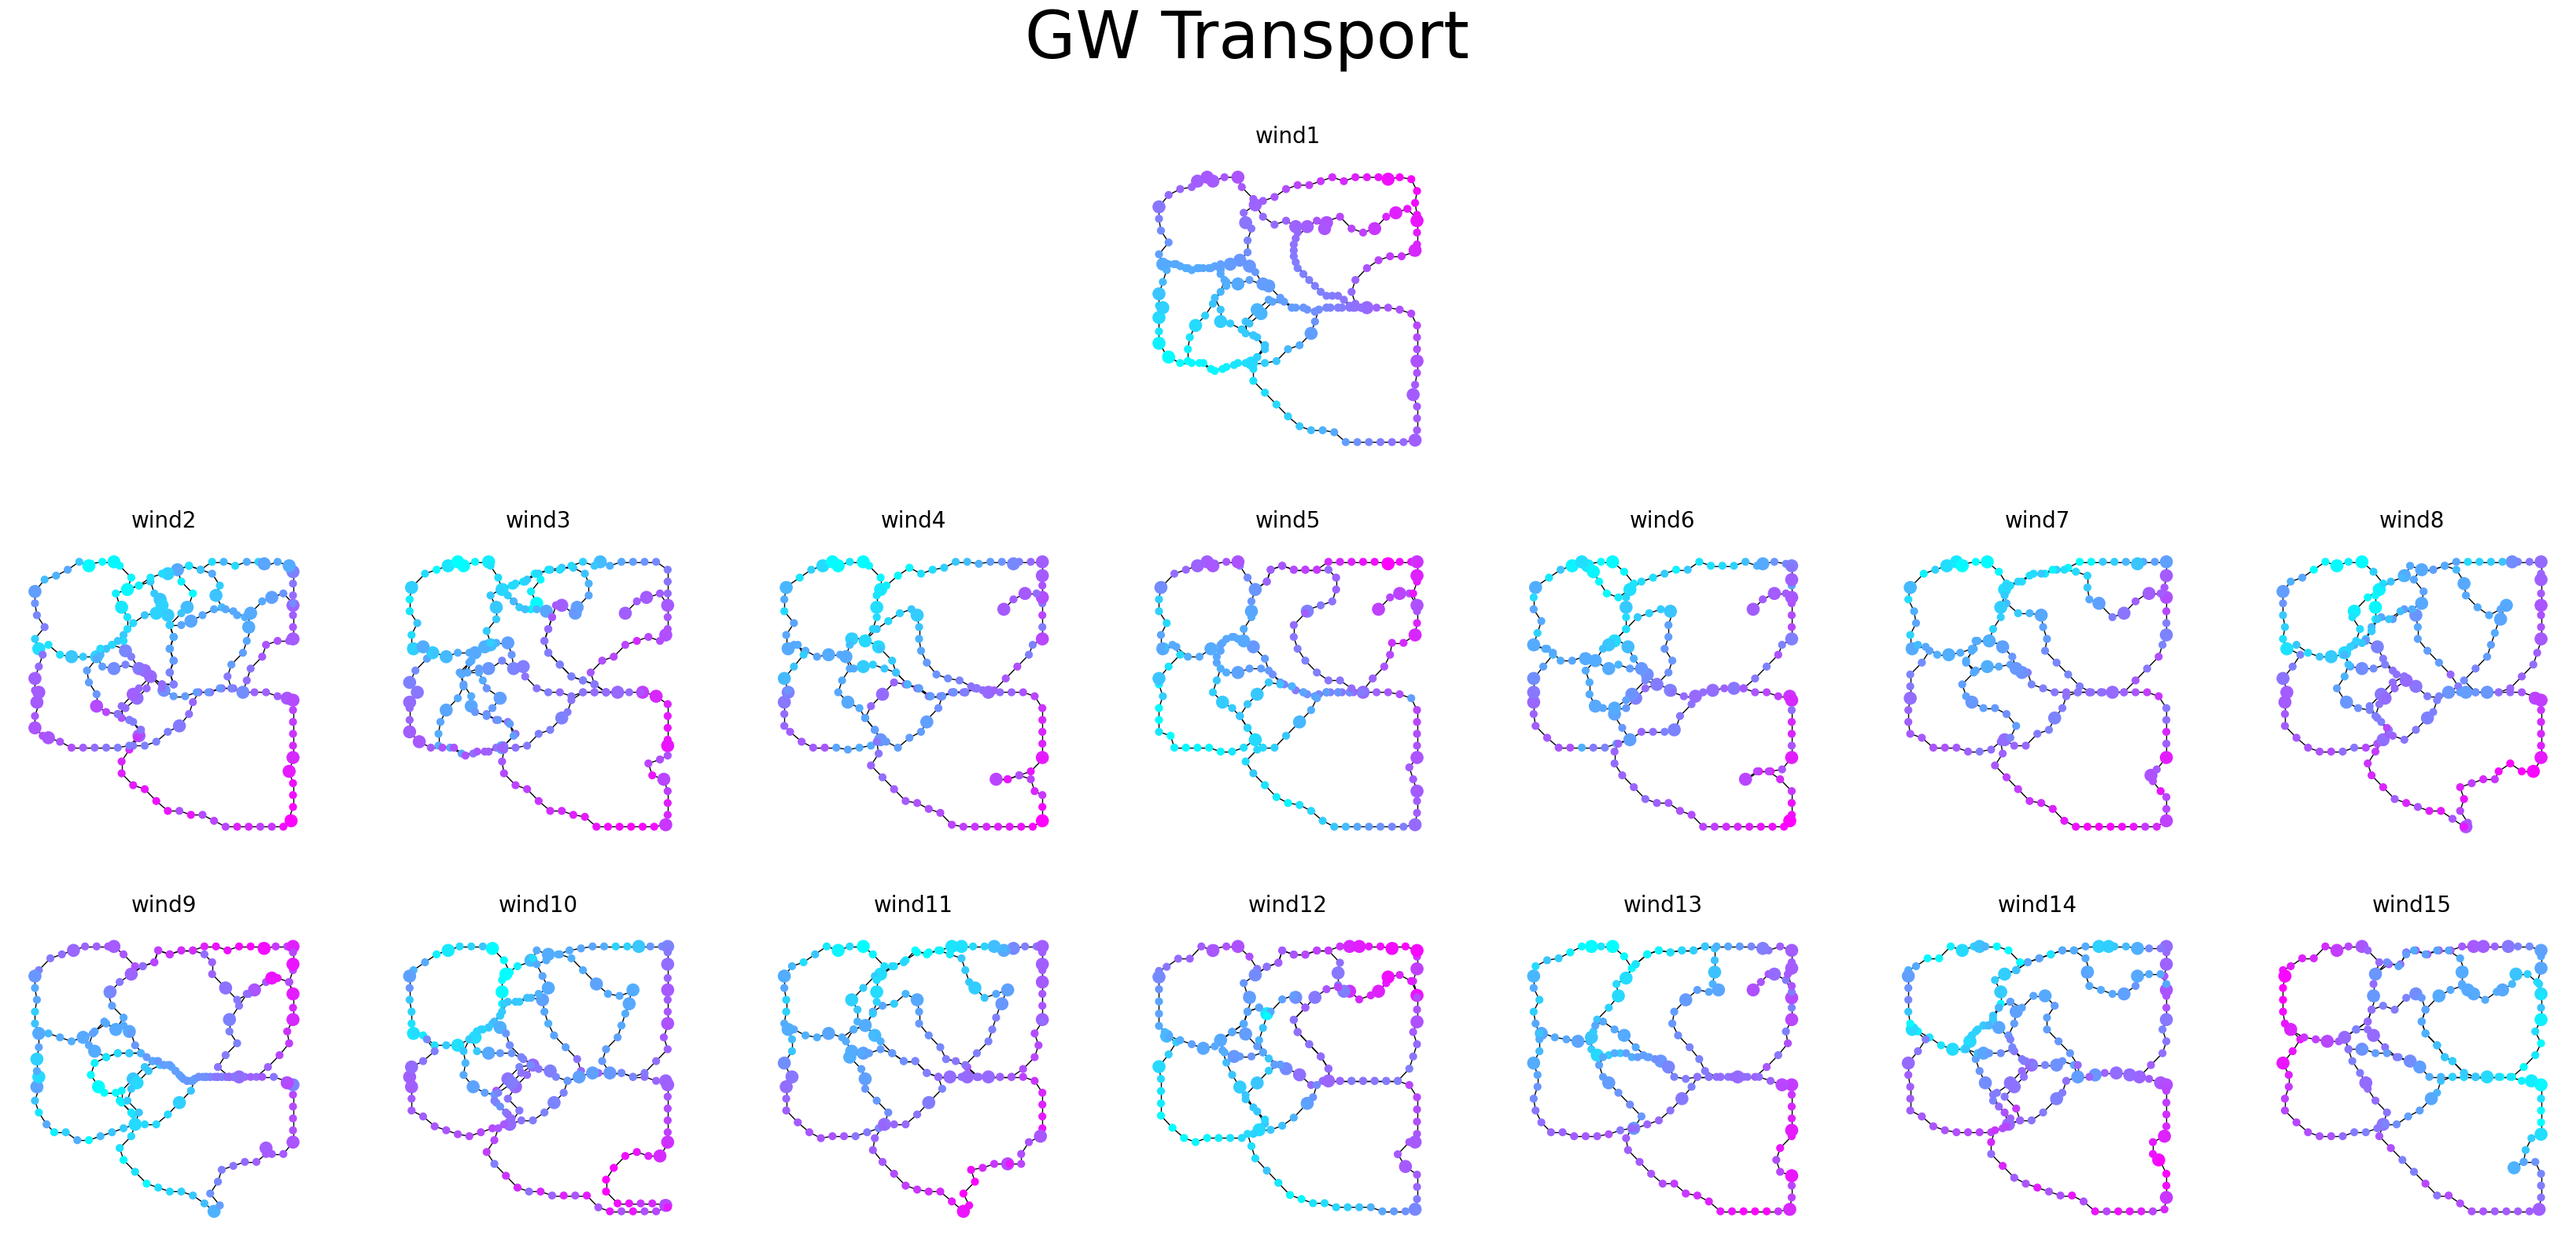

In [9]:
fig = display_results('GW')
fig.suptitle('GW Transport', fontsize=60)

Text(0.5, 0.98, 'Fused GW Transport')

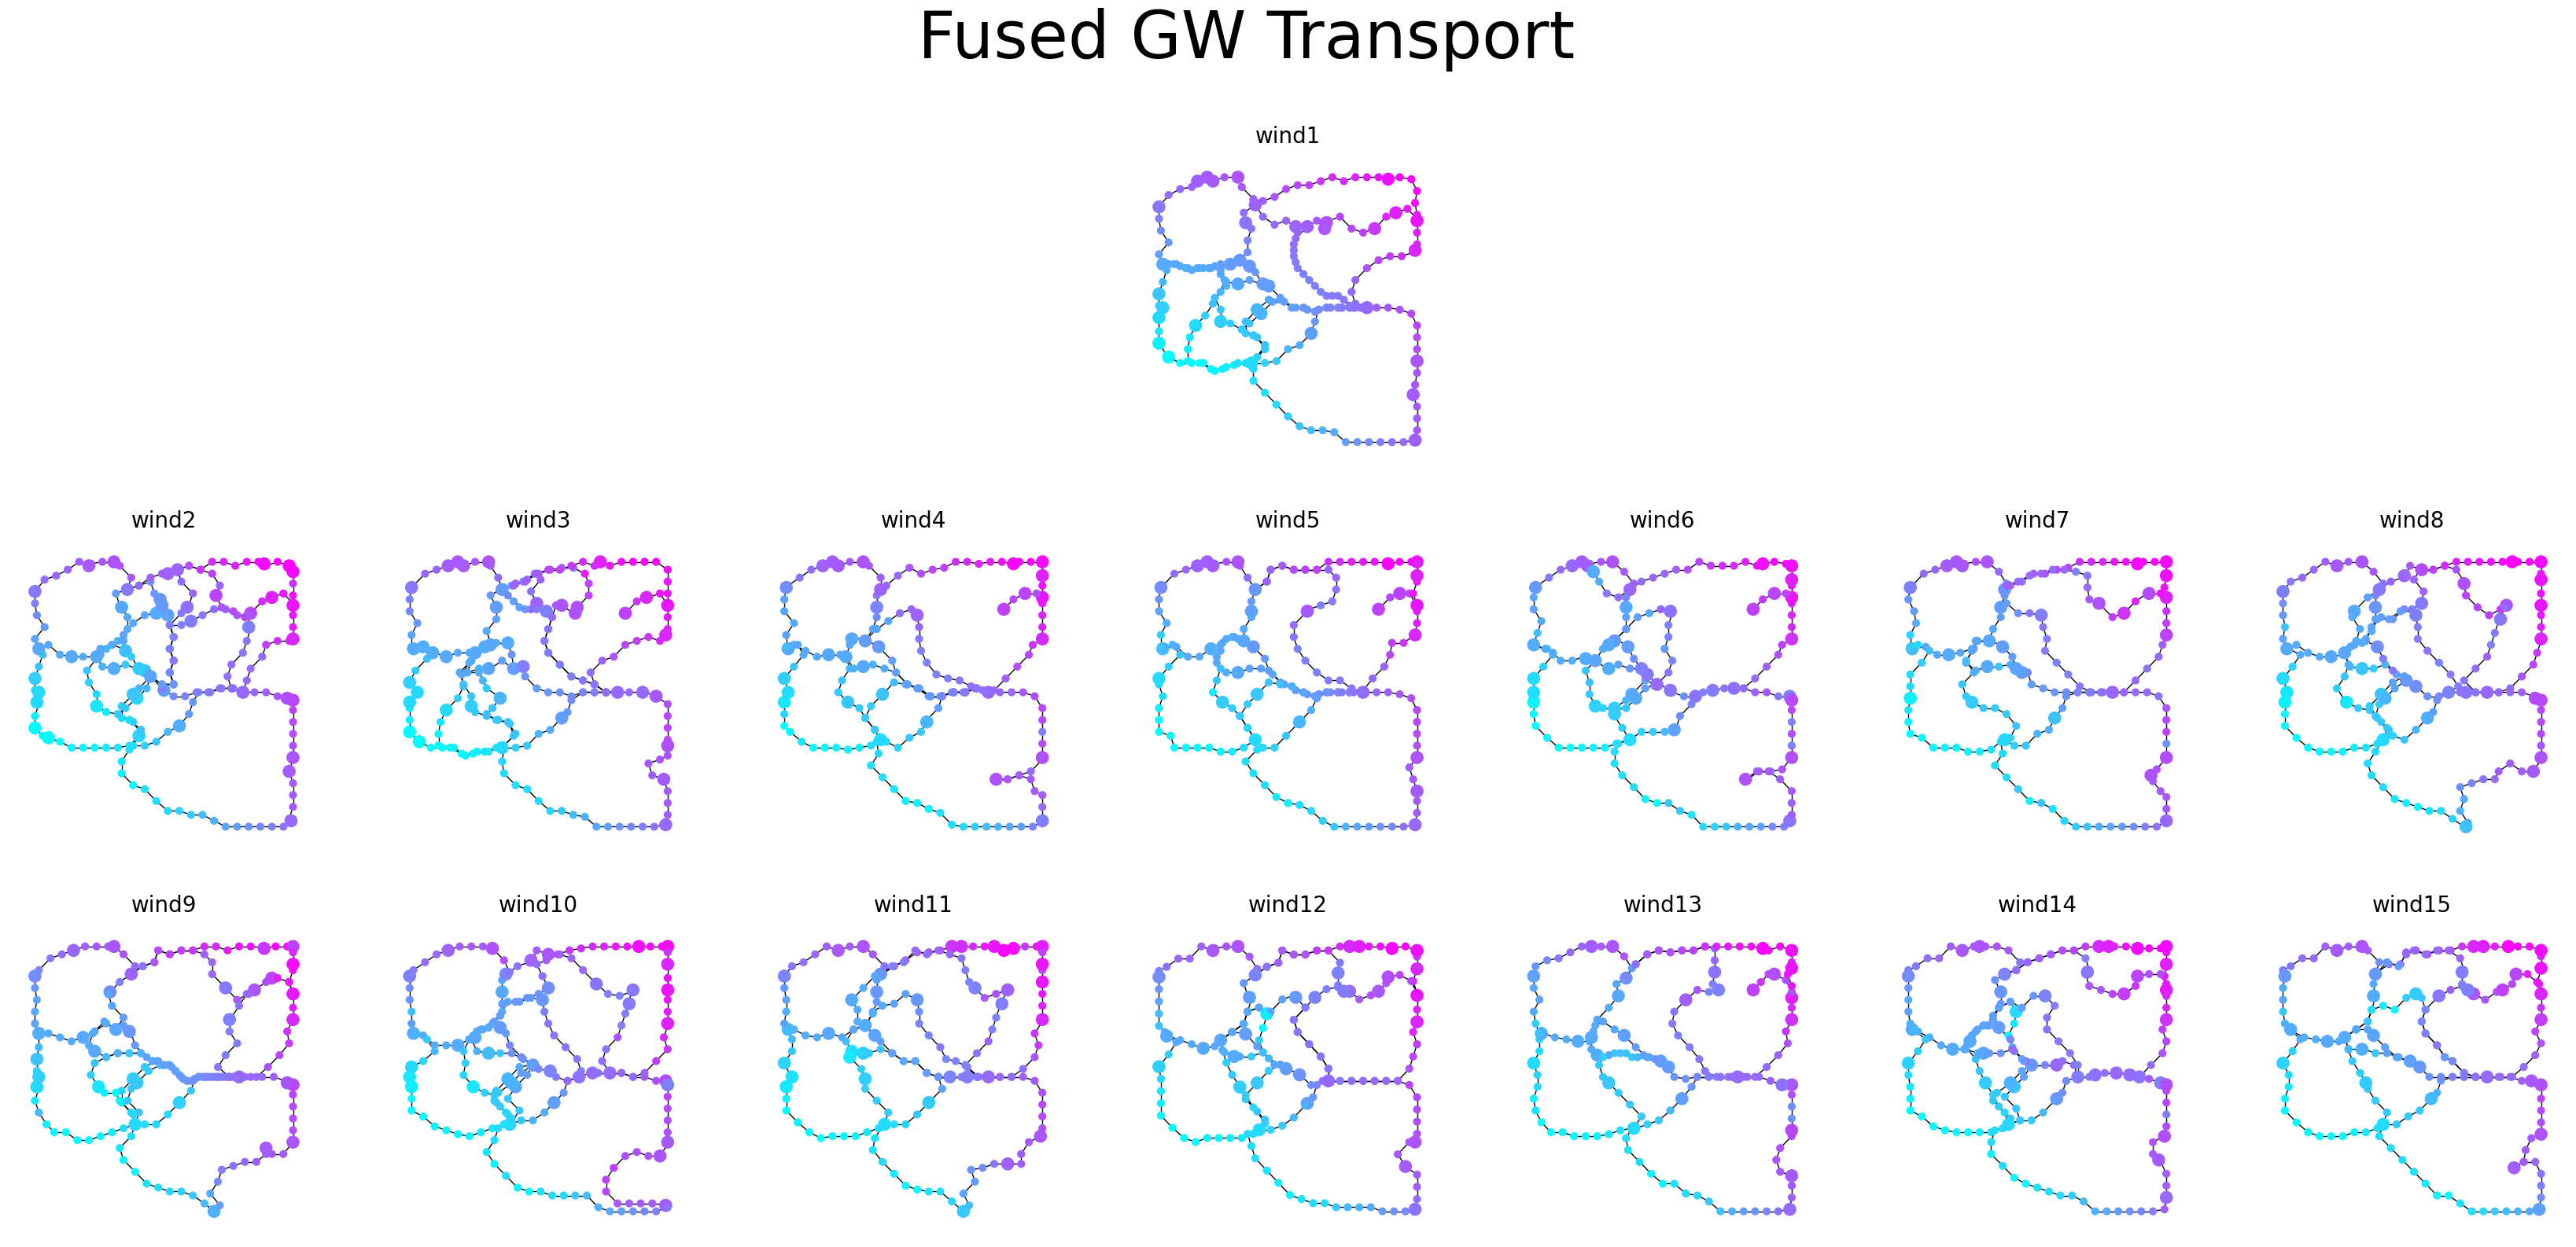

In [10]:
fig = display_results('fGW')
fig.suptitle('Fused GW Transport', fontsize=60)

Text(0.5, 0.98, 'Partial Fused GW Transport')

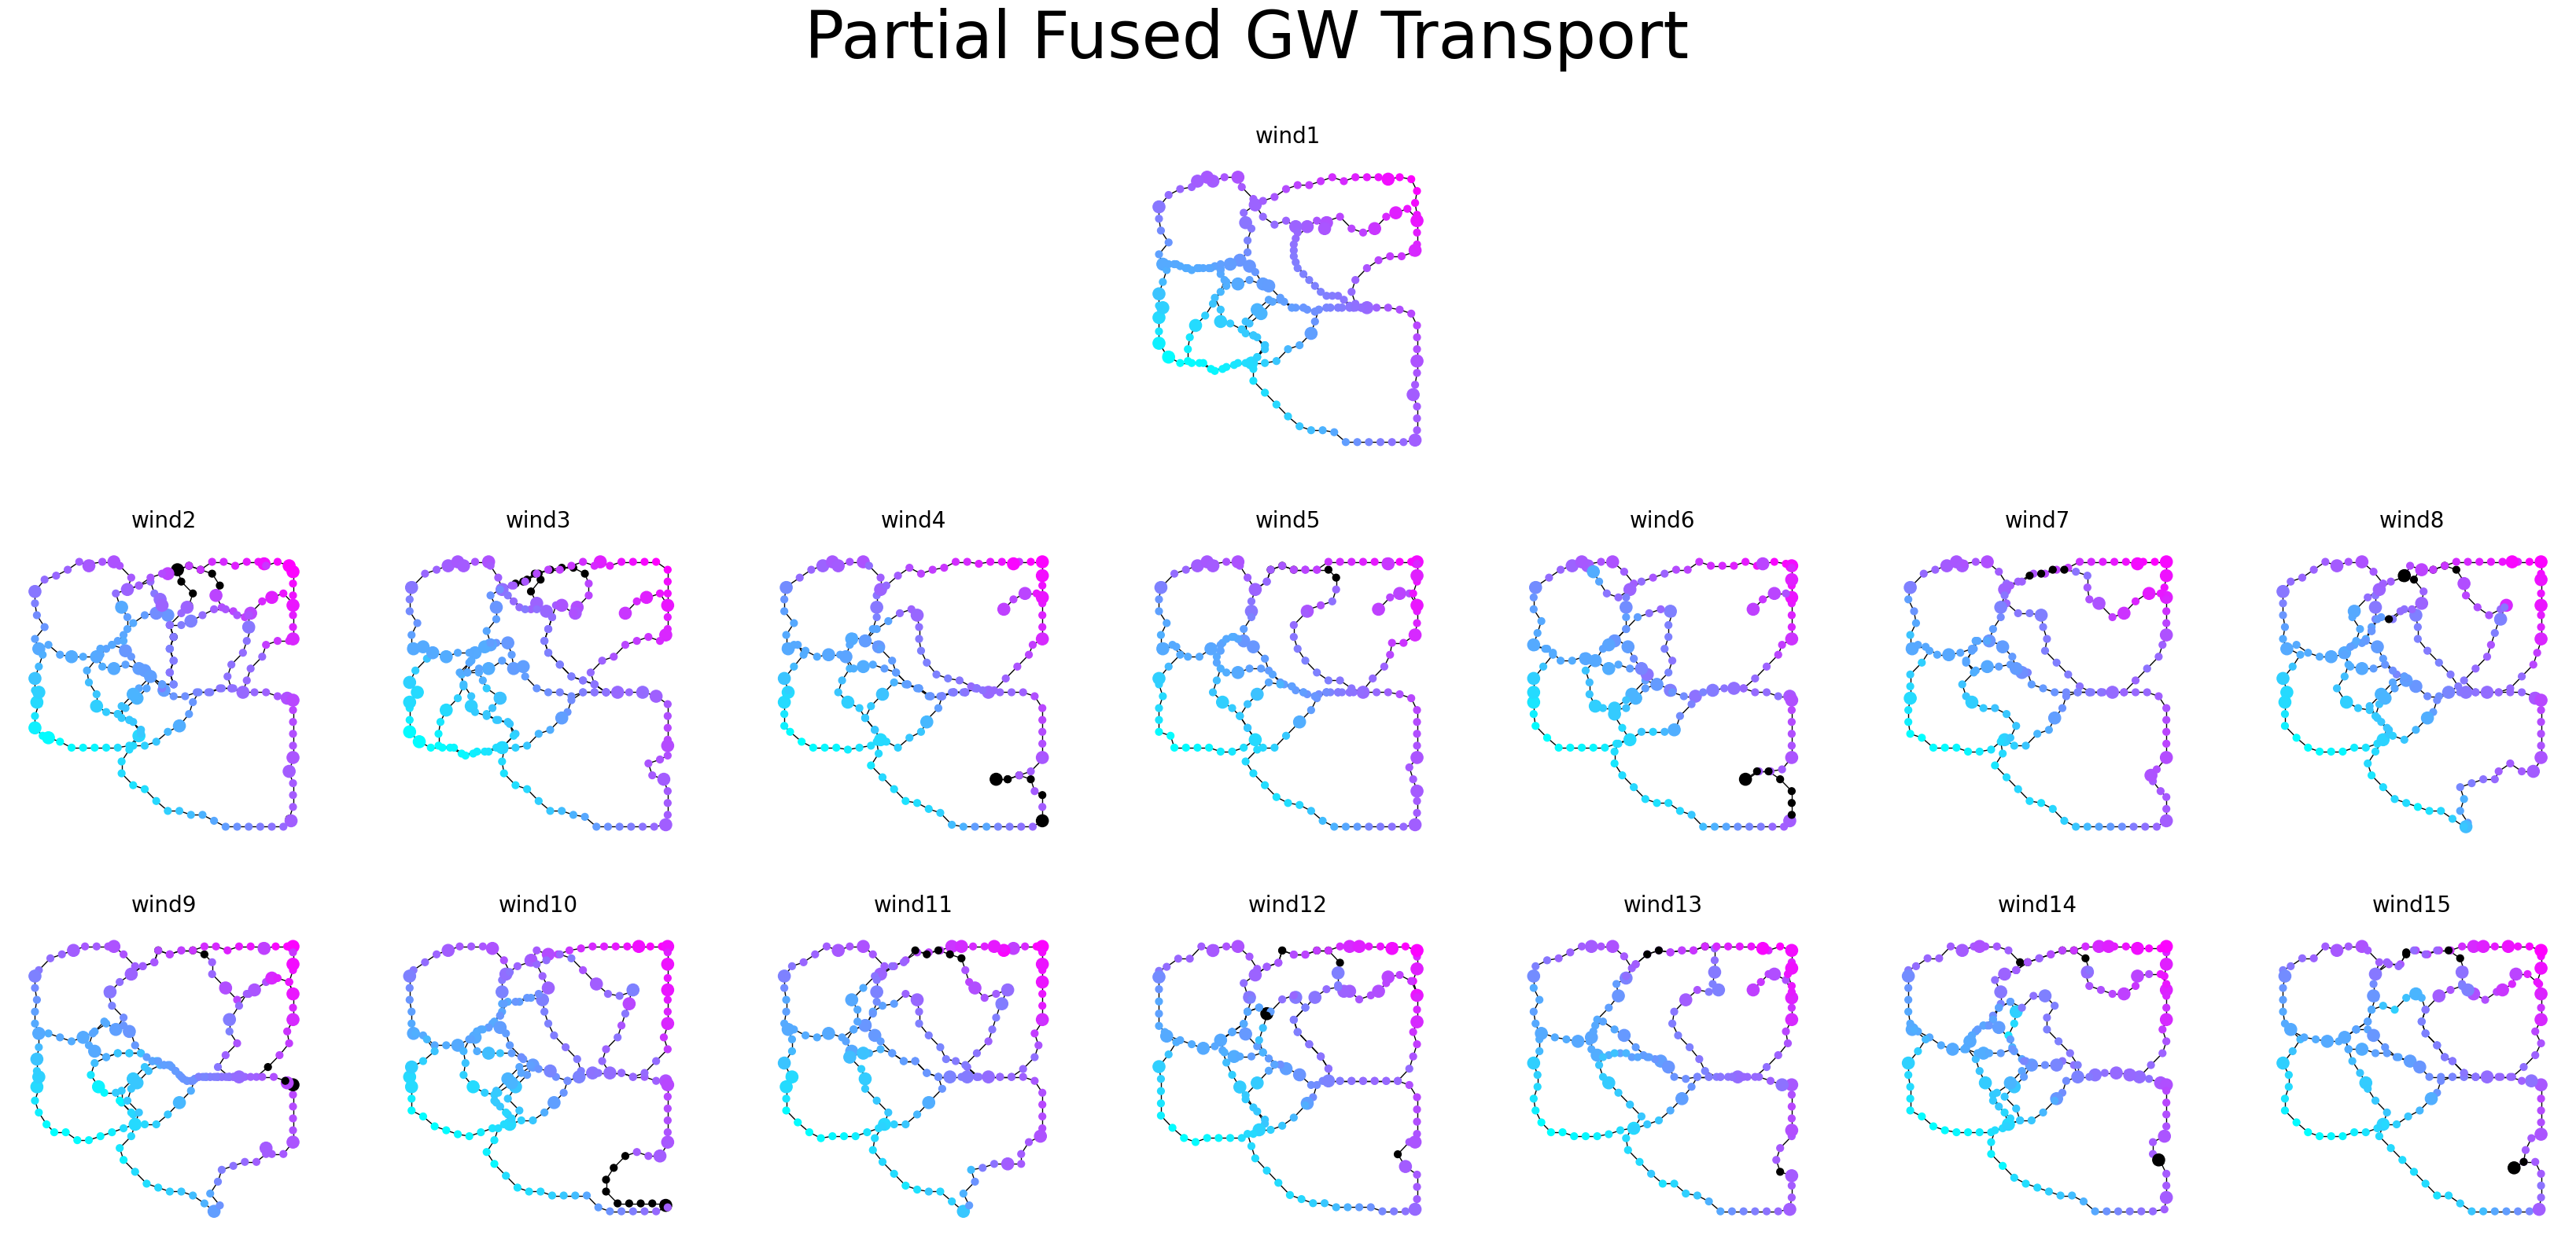

In [11]:
fig = display_results('fpGW')
fig.suptitle('Partial Fused GW Transport', fontsize=60)